In [1]:
import matplotlib.pyplot as plt
import random

from PIL import Image
from functools import partial
import scipy.ndimage as ndi
import numpy as np
import torch
import torch.nn.functional as F
from skimage.morphology import skeletonize

import os
import numpy as np

import os 
import sys

# Functions

## Utils

In [2]:


# Transform the list of images to a tensor
def img_to_tensor(imgs):
    """Transforma uma lista de imagens em um tensor
    Parameters
    ----------
    imgs : list
        Lista de imagens
    Returns
    -------
    imgs : torch.Tensor
        Tensor com as imagens
    """
    imgs = torch.Tensor(imgs)
    return imgs

# Função para carregar as imagens e aplicar transformações personalizadas
def img_opener(image_path, resize=False, size=(256, 256)):
    """Carrega as imagens de um diretório e aplica transformações personalizadas
    Parameters
    ----------
    image_path : str
        Caminho para o diretório de imagens (TIFF)
    size : tuple, optional
        O tamanho desejado das imagens (largura, altura), por padrão (256, 256)
    Returns
    -------
    imgs : np.array
        Array de imagens após as transformações
    """
    imgs = []
    filenames = sorted(os.listdir(image_path))  # Get the sorted list of filenames
    for filename in filenames:
        file_path = os.path.join(image_path, filename)       
        
        # Carrega a imagem TIFF
        img = Image.open(file_path)
        
        if resize:
            # Redimensiona a imagem para o tamanho desejado
            img = img.resize(size)
        
        img = np.array(img)  # Converta a imagem para um array NumPy
        imgs.append(img)
        
    # Converte a lista de imagens para um array NumPy
    imgs = np.stack(imgs)
    
    return imgs


In [3]:
def plot_examples(imgs, masks, pred1, pred2, n=6):
    """
    Plot some example segmentations.

    Args:
        imgs (list): List of input images.
        masks (list): List of ground truth masks.
        pred1 (list): List of predicted masks using Tosnet.
        pred2 (list): List of predicted masks using Tosnet Finetuned.
        n (int, optional): Number of examples to plot. Defaults to 6.
    """

    indices = random.sample(range(len(imgs)), n)  # Randomly draw some indices
    for i, idx in enumerate(indices):

        x = imgs[idx]
        y = masks[idx]
        y_pred1 = pred1[idx]
        y_pred2 = pred2[idx]
        
        iou1, cldice1 = measures(y_pred1/255, y/255)
        iou2, cldice2 = measures(y_pred2/255, y/255)          


        plt.figure(figsize=[15,5])
        plt.subplot(1, 4, 1)
        plt.imshow(x, 'gray')
        plt.title('Original image')
        plt.subplot(1, 4, 2)
        plt.imshow(y, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 4, 3)
        plt.imshow(y_pred1, 'gray')
        plt.title(f'Prediction Tosnet.\nIoU: {iou1:.2f} - ClDice: {cldice1:.2f}')
        plt.subplot(1, 4, 4)
        plt.imshow(y_pred2, 'gray')
        plt.title(f'Prediction Tosnet Finetuned.\nIoU: {iou2:.2f} - ClDice: {cldice2:.2f}')
        
        
def mean_measures(pred, mask):
    """Calcula a média das métricas de desempenho
    Parameters
    ----------
    pred : list
        Lista de máscaras preditas
    mask : list
        Lista de máscaras do ground truth
    Returns
    -------
    iou_mean : float
        Média da medida IoU
    cldice_mean : float
        Média da medida clDice
    """
    iou_mean = 0
    cldice_mean = 0
    for i in range(len(pred)):
        iou, cldice = measures(pred[i], mask[i])
        iou_mean += iou
        cldice_mean += cldice
    iou_mean /= len(pred)
    cldice_mean /= len(pred)
    return iou_mean, cldice_mean


## Performance evaluation

In [4]:
'''Functions for measuring the performance of a classifier.'''

def iou(mask_pred, mask_gt):
    '''Calcula a Intersection over Union (IoU) entre duas máscaras binárias.

    Parâmetros
    ----------
    mask_gt : numpy.array
        Máscara binária do ground truth.
    mask_pred : numpy.array
        Máscara binária predita.

    Retorna
    -------
    iou : float
        A medida Intersection over Union entre as duas máscaras.
    '''

    intersection = np.logical_and(mask_gt, mask_pred)
    union = np.logical_or(mask_gt, mask_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def cl_score(image, skeleton):
    ''' Calculate the skeleton volume overlap
    
    Parameters
    ----------
    image : numpy.array
        binary image.
    skeleton : numpy.array
        skeleton of tubular structures from image. 
    
    Returns
    -------    
    score : float
        Computed skeleton volume intersection
    
    '''
    
    score = np.sum(image*skeleton)/np.sum(skeleton)
    
    return score


def clDice(mask_pred, mask_gt):
    ''' Compute the centerlineDice metric. ClDice is calculated on the intersection of the segmentation results and their skeleta.  
    
    Parameters
    ----------
    mask_pred : numpy.array
        Predicted binary mask.
    mask_gt : numpy.array
        Ground truth binary mask.
    
    Returns
    -------    
    cldice : float
        
    '''
    
    tprec = cl_score(mask_gt, skeletonize(mask_pred))
    tsens = cl_score(mask_pred, skeletonize(mask_gt))
    
    cldice = 2*tprec*tsens / (tprec+tsens)
    
    return cldice

def measures(mask_pred, mask_gt):
    '''Calcula as métricas de desempenho entre duas máscaras binárias.

    Parâmetros
    ----------
    mask_gt : numpy.array
        Máscara binária do ground truth.
    mask_pred : numpy.array
        Máscara binária predita.

    Retorna
    -------
    jaccard : float
        A medida Jaccard entre as duas máscaras.
    cldice_score : float
        A medida clDice entre as duas máscaras.
    '''

    iou_score = iou(mask_pred, mask_gt)
    cldice_score = clDice(mask_pred, mask_gt)
    return iou_score, cldice_score

# Evaluation

## Load Segment Anything Model

In [5]:
from autodistill_grounded_sam import GroundedSAM
from autodistill.detection import CaptionOntology
from autodistill.utils import plot


## Vessels

In [6]:
orig_img_path = 'data/vessels/images'
mask_path = 'data/vessels/masks'
pred_tosnet_path = 'data/vessels/predicted_tosnet'
pred_tosnet_ft_path = 'data/vessels/predicted_tosnet_finetuned'

imgs = img_opener(orig_img_path)
masks = img_opener(mask_path)

pred_tosnet= img_opener(pred_tosnet_path)
pred_tosnet_finetuned = img_opener(pred_tosnet_ft_path)


# predicted = [y > 127 for y in predicted]

In [16]:
CaptionOntology.prompts

<function autodistill.detection.caption_ontology.CaptionOntology.prompts(self) -> List[str]>

In [ ]:
class_names = ['vessel']
sam = GroundedSAM(
    ontology=CaptionOntology(
        {
            "vessel": "vessel"
        }
    )
)

results, _, _ = sam.predict(imgs[0])


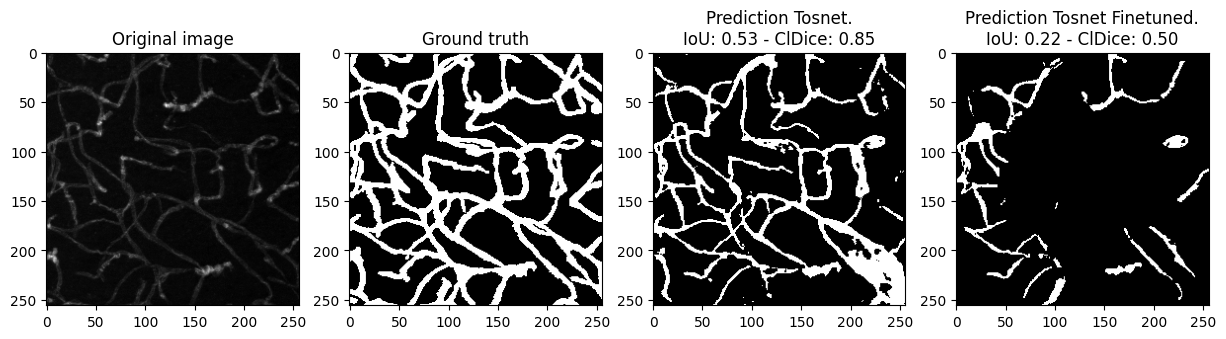

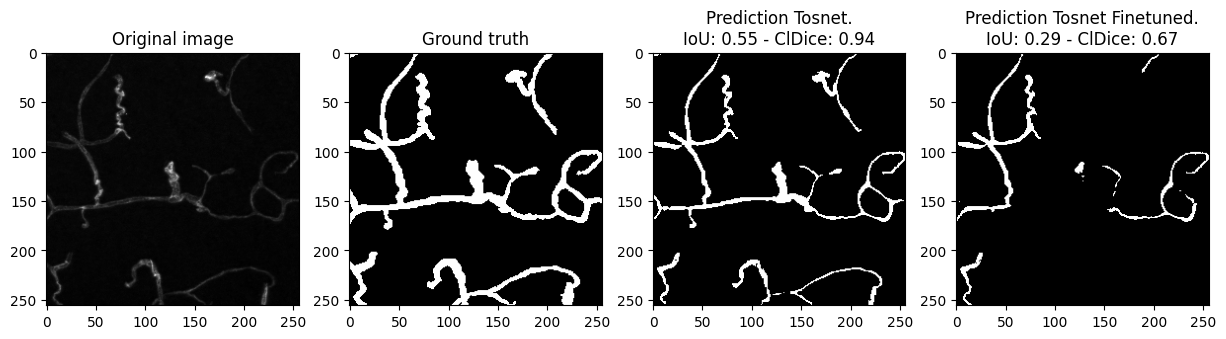

In [27]:
plot_examples(imgs, masks, pred_tosnet, pred_tosnet_finetuned, n=2)

In [125]:
%%time

tosnet_iou, tosnet_cldice = measures(pred_tosnet/255, mask/255)
tosnet_ft_iou, tosnet_ft_cldice = measures(pred_tosnet_finetuned/255, mask/255)

print(f'TosNet\n  IoU: {tosnet_iou:.2f} - ClDice: {tosnet_cldice:.2f}')
print(f'TosNet Finetuned\n  IoU: {tosnet_ft_iou:.2f} - ClDice: {tosnet_ft_cldice:.2f}')
print('')

TosNet
  IoU: 0.47 - ClDice: 0.70
TosNet Finetuned
  IoU: 0.22 - ClDice: 0.45

CPU times: user 2.63 s, sys: 64 ms, total: 2.69 s
Wall time: 2.69 s


## COIFT

In [23]:
coift_orig_img_path = 'data/coift/images'
coift_mask_path = 'data/coift/masks'
coift_pred_tosnet_path = 'data/coift/predicted_tosnet'
coift_pred_tosnet_ft_path = 'data/coift/predicted_tosnet_finetuned'

coift_imgs = img_opener(coift_orig_img_path, resize=True)
coift_masks = img_opener(coift_mask_path, resize=True)

coift_pred_tosnet= img_opener(coift_pred_tosnet_path, resize=True)
coift_pred_tosnet_finetuned = img_opener(coift_pred_tosnet_ft_path, resize=True)

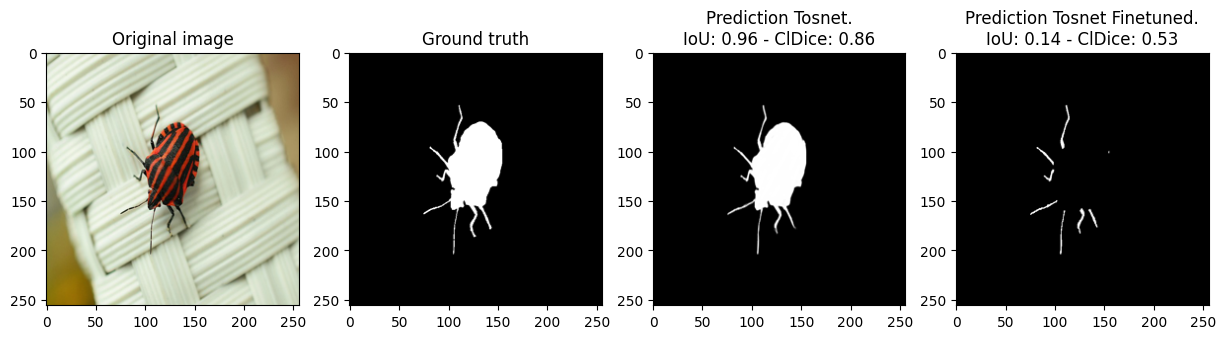

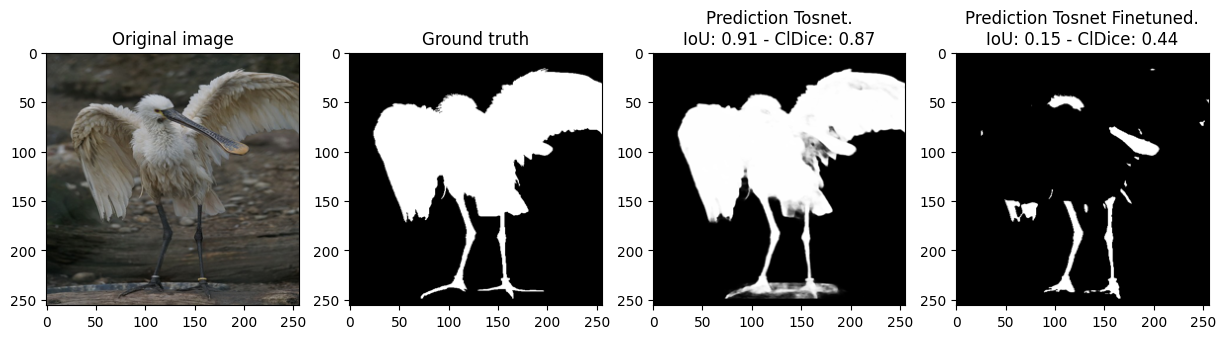

In [24]:
plot_examples(coift_imgs, coift_masks, coift_pred_tosnet, coift_pred_tosnet_finetuned, n=2)

In [132]:
%%time

tosnet_iou, tosnet_cldice = measures(coift_pred_tosnet/255, coift_masks/255)
tosnet_ft_iou, tosnet_ft_cldice = measures(coift_pred_tosnet_finetuned/255, coift_masks/255)

print(f'TosNet\n  IoU: {tosnet_iou:.2f} - ClDice: {tosnet_cldice:.2f}')
print(f'TosNet Finetuned\n  IoU: {tosnet_ft_iou:.2f} - ClDice: {tosnet_ft_cldice:.2f}')
print('')

TosNet
  IoU: 0.79 - ClDice: 0.75
TosNet Finetuned
  IoU: 0.19 - ClDice: 0.52

CPU times: user 8.95 s, sys: 136 ms, total: 9.09 s
Wall time: 9.09 s
